In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Parameter
import torch.utils.data as Data
from torch.utils.data import RandomSampler
from torch.utils.data import Dataset,DataLoader,TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pennylane as qml
import pytorch_lightning as pl
import math
import time


In [2]:
dfi = pd.read_csv('./Data/Stock/^GSPC.csv',parse_dates=True,index_col='Datetime')
dfi

,Close,High,Low,Open
Datetime,,,,
2022-10-31 13:30:00+00:00,3868.510010,3884.610107,3863.179932,3877.560059
2022-10-31 14:30:00+00:00,3883.570068,3886.030029,3863.939941,3868.550049
2022-10-31 15:30:00+00:00,3879.719971,3893.729980,3874.709961,3883.530029
2022-10-31 16:30:00+00:00,3883.560059,3883.889893,3868.469971,3879.719971
2022-10-31 17:30:00+00:00,3879.780029,3885.629883,3875.439941,3883.389893
...,...,...,...,...
2024-10-28 15:30:00+00:00,5833.310059,5834.930176,5824.310059,5834.020020
2024-10-28 16:30:00+00:00,5831.490234,5834.120117,5824.779785,5833.379883
2024-10-28 17:30:00+00:00,5831.359863,5836.049805,5830.689941,5831.540039


In [3]:
# df = dfi.loc[dfi['pickup_datetime'] > '2016-08-01']
# df

In [4]:
df = dfi[['Open','High','Low','Close']]
df = df.dropna()
#df = df.reset_index(drop=True)
df

,Open,High,Low,Close
Datetime,,,,
2022-10-31 13:30:00+00:00,3877.560059,3884.610107,3863.179932,3868.510010
2022-10-31 14:30:00+00:00,3868.550049,3886.030029,3863.939941,3883.570068
2022-10-31 15:30:00+00:00,3883.530029,3893.729980,3874.709961,3879.719971
2022-10-31 16:30:00+00:00,3879.719971,3883.889893,3868.469971,3883.560059
2022-10-31 17:30:00+00:00,3883.389893,3885.629883,3875.439941,3879.780029
...,...,...,...,...
2024-10-28 15:30:00+00:00,5834.020020,5834.930176,5824.310059,5833.310059
2024-10-28 16:30:00+00:00,5833.379883,5834.120117,5824.779785,5831.490234
2024-10-28 17:30:00+00:00,5831.540039,5836.049805,5830.689941,5831.359863


In [5]:
df['nxt_target'] = df['Close'].shift(-1)
df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]

/tmp/ipykernel_1876/2437957435.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]
/tmp/ipykernel_1876/2437957435.py:2: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3491 entries, 2022-10-31 13:30:00+00:00 to 2024-10-28 19:30:00+00:00
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        3491 non-null   float64
 1   High        3491 non-null   float64
 2   Low         3491 non-null   float64
 3   Close       3491 non-null   float64
 4   nxt_target  3491 non-null   float64
dtypes: float64(5)
memory usage: 163.6 KB


In [7]:
size = int(len(df) * 0.8)

train = df.iloc[:size].copy()
test = df.iloc[size:].copy()
train

,Open,High,Low,Close,nxt_target
Datetime,,,,,
2022-10-31 13:30:00+00:00,3877.560059,3884.610107,3863.179932,3868.510010,3883.570068
2022-10-31 14:30:00+00:00,3868.550049,3886.030029,3863.939941,3883.570068,3879.719971
2022-10-31 15:30:00+00:00,3883.530029,3893.729980,3874.709961,3879.719971,3883.560059
2022-10-31 16:30:00+00:00,3879.719971,3883.889893,3868.469971,3883.560059,3879.780029
2022-10-31 17:30:00+00:00,3883.389893,3885.629883,3875.439941,3879.780029,3876.449951
...,...,...,...,...,...
2024-06-04 19:30:00+00:00,5283.830078,5293.009766,5278.040039,5290.740234,5310.259766
2024-06-05 13:30:00+00:00,5314.479980,5316.299805,5297.640137,5310.259766,5327.160156
2024-06-05 14:30:00+00:00,5310.299805,5329.299805,5310.299805,5327.160156,5329.500000


In [8]:
train.iloc[:,-1:]

,nxt_target
Datetime,
2022-10-31 13:30:00+00:00,3883.570068
2022-10-31 14:30:00+00:00,3879.719971
2022-10-31 15:30:00+00:00,3883.560059
2022-10-31 16:30:00+00:00,3879.780029
2022-10-31 17:30:00+00:00,3876.449951
...,...
2024-06-04 19:30:00+00:00,5310.259766
2024-06-05 13:30:00+00:00,5327.160156
2024-06-05 14:30:00+00:00,5329.500000


In [9]:
train.iloc[:,:4]

,Open,High,Low,Close
Datetime,,,,
2022-10-31 13:30:00+00:00,3877.560059,3884.610107,3863.179932,3868.510010
2022-10-31 14:30:00+00:00,3868.550049,3886.030029,3863.939941,3883.570068
2022-10-31 15:30:00+00:00,3883.530029,3893.729980,3874.709961,3879.719971
2022-10-31 16:30:00+00:00,3879.719971,3883.889893,3868.469971,3883.560059
2022-10-31 17:30:00+00:00,3883.389893,3885.629883,3875.439941,3879.780029
...,...,...,...,...
2024-06-04 19:30:00+00:00,5283.830078,5293.009766,5278.040039,5290.740234
2024-06-05 13:30:00+00:00,5314.479980,5316.299805,5297.640137,5310.259766
2024-06-05 14:30:00+00:00,5310.299805,5329.299805,5310.299805,5327.160156


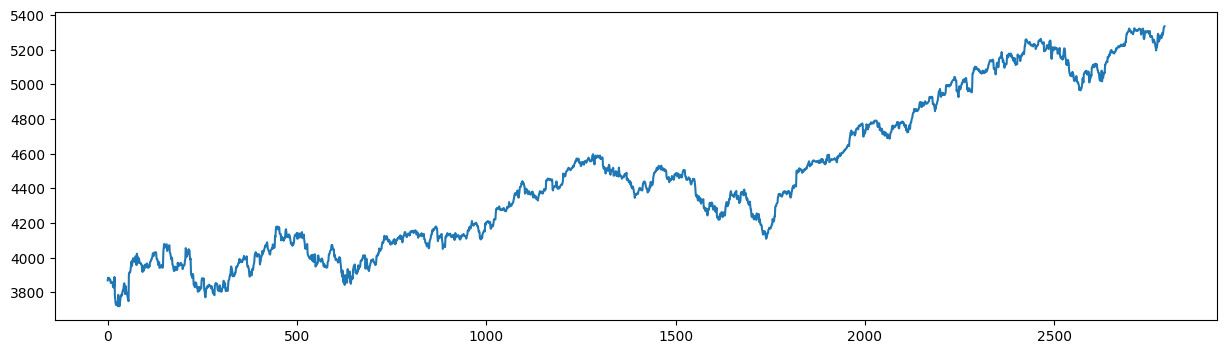

In [10]:
%matplotlib inline
plt.figure(figsize=(15, 4))
plt.plot(range(len(train)), train["Close"])
plt.show()

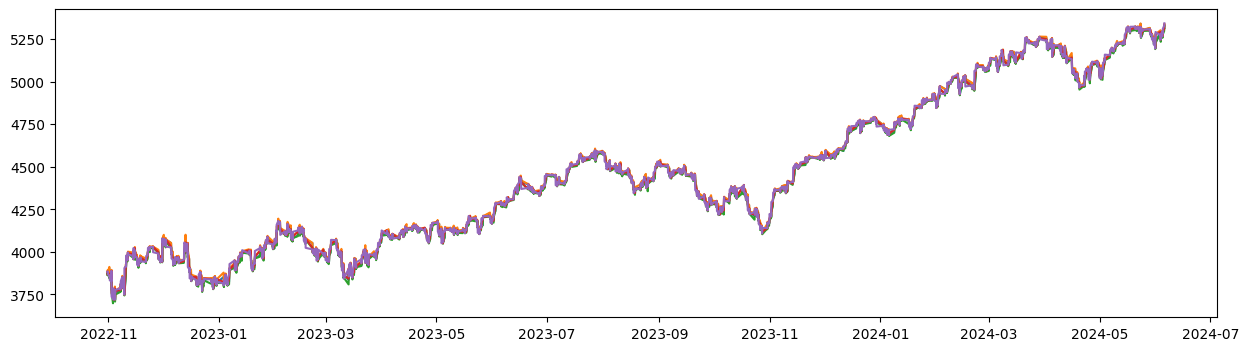

In [11]:
plt.figure(figsize=(15, 4))
plt.plot(train)
plt.show()

In [12]:
def data_process(data, window_size, predict_size):
    scaler1 = StandardScaler()
    scaler2 = StandardScaler()
    d_y = scaler1.fit_transform(data.iloc[:,-1:])
    data = scaler2.fit_transform(data.iloc[:,:4])

    data_in = []
    data_out = []
    # range(window_size,len(data)-predict_size+1) range(data.shape[0] - window_size - predict_size + 1)
    for i in range(window_size,len(data)-predict_size+1):
        data_in.append(data[i-window_size:i,0:data.shape[0]])
        data_out.append(d_y[i + predict_size - 1:i + predict_size,0])

    data_in = np.array(data_in)
    data_out = np.array(data_out)

    data_process = {'datain': data_in, 'dataout': data_out}

    return data_process, scaler1 , scaler2

In [13]:
from numpy.random import default_rng
from qiskit_algorithms.utils import algorithm_globals
qubits = 4
seed = 42
np.random.seed(seed)
torch.manual_seed(42)
rng = default_rng(seed)
algorithm_globals.random_seed = seed
features_size = 4
#window_size = features_size * 3
window_size = 10
predict_size = 1

In [14]:
train_processed, train_target_scalar, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_target_scalar, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [15]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [16]:
print(X_train.shape)
X_train[0][0]

torch.Size([2782, 10, 4])


tensor([-1.3100, -1.3146, -1.3223, -1.3311])

In [17]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            bidirectional=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers *2 , batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [18]:
batch_size = 4
learning_rate = 0.004
num_epochs = 5
trainDataloader = DataLoader(TensorDataset(X_train, y_train), batch_size = batch_size, shuffle = False)
testDataloader = DataLoader(TensorDataset(X_test,y_test), batch_size = batch_size, shuffle = False)
device = "cpu"
modelQ = ShallowRegressionLSTM(num_sensors=4, hidden_units= 6)
criterion = nn.MSELoss()
optimizerQ = torch.optim.Adam(modelQ.parameters(), lr = learning_rate, betas = (0.0, 0.9))

In [19]:
histQ = np.zeros(num_epochs)
histQacc = np.zeros(num_epochs)

count = 0
for epoch in range(num_epochs):
    loss_Q = []
    rmse_q = []
    correct = 0
    batches = 0
    for (x, y) in trainDataloader:
        modelQ.zero_grad()
        x = x.to(device)
        y = y.to(device)
        
        output = modelQ(x)

        label = y.squeeze(1)
        #print(output)
        #print(label)
        lossQ = criterion(output, label)
        lossQ.backward()
        optimizerQ.step()
        
        #correct += (output == label).float().sum()
        #batches +=1
        
        loss_Q.append(lossQ.item())
    histQ[epoch] = np.sum(loss_Q)
    
    #print(correct)
    #histQacc[epoch] = correct/batches
    print(f'[{epoch+1}/{num_epochs}]  LossQ:{np.sum(loss_Q)} ')

[1/5]  LossQ:29.734429167634516 
[2/5]  LossQ:9.588828816187743 
[3/5]  LossQ:10.198949446426013 
[4/5]  LossQ:9.328961583851196 
[5/5]  LossQ:8.975180449560867 


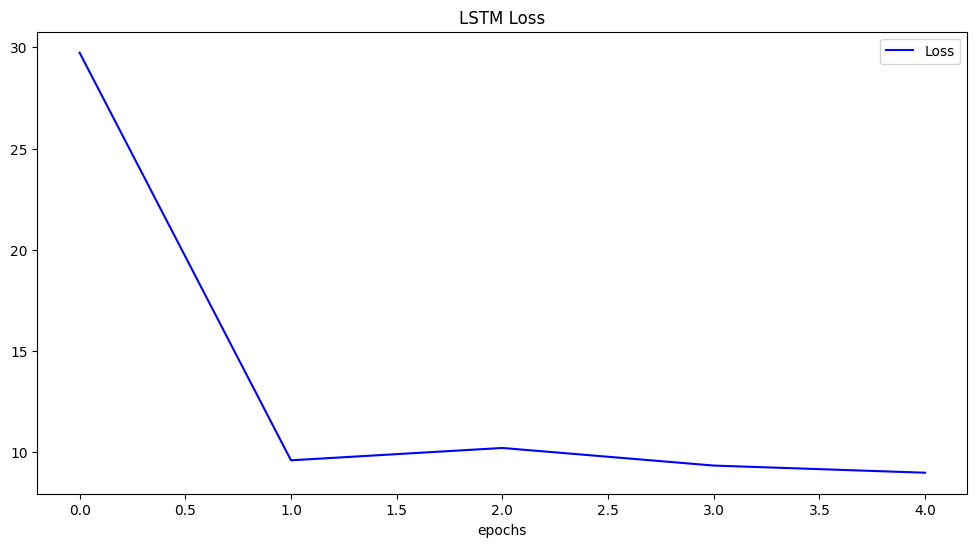

In [20]:
np.savetxt('./SavedModels/Stock/SNP500/loss/cblstm.txt',histQ)
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'Loss')
plt.title('LSTM Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')

In [21]:
pred_y_train = modelQ(X_train)
pred_y_test = modelQ(X_test)

print(pred_y_train)

tensor([-0.4138, -0.4142, -0.4148,  ...,  1.9886,  1.9905,  1.9936],
       grad_fn=<ViewBackward0>)


In [22]:
pred_y_train = pred_y_train.reshape(-1, 1)
pred_y_test = pred_y_test.reshape(-1, 1)


In [23]:
pred_y_train

tensor([[-0.4138],
        [-0.4142],
        [-0.4148],
        ...,
        [ 1.9886],
        [ 1.9905],
        [ 1.9936]], grad_fn=<ViewBackward0>)

In [24]:
y_train_true = train_target_scalar.inverse_transform(y_train)
y_train_pred = train_target_scalar.inverse_transform(pred_y_train.cpu().detach().numpy())
y_test_true = test_target_scalar.inverse_transform(y_test)
y_test_pred = test_target_scalar.inverse_transform(pred_y_test.cpu().detach().numpy())

In [25]:
np.savetxt('./SavedModels/Stock/SNP500/train/cblstm.txt',y_train_pred)
np.savetxt('./SavedModels/Stock/SNP500/test/cblstm.txt',y_test_pred)

Training dataset RMSE:253.4818430461884


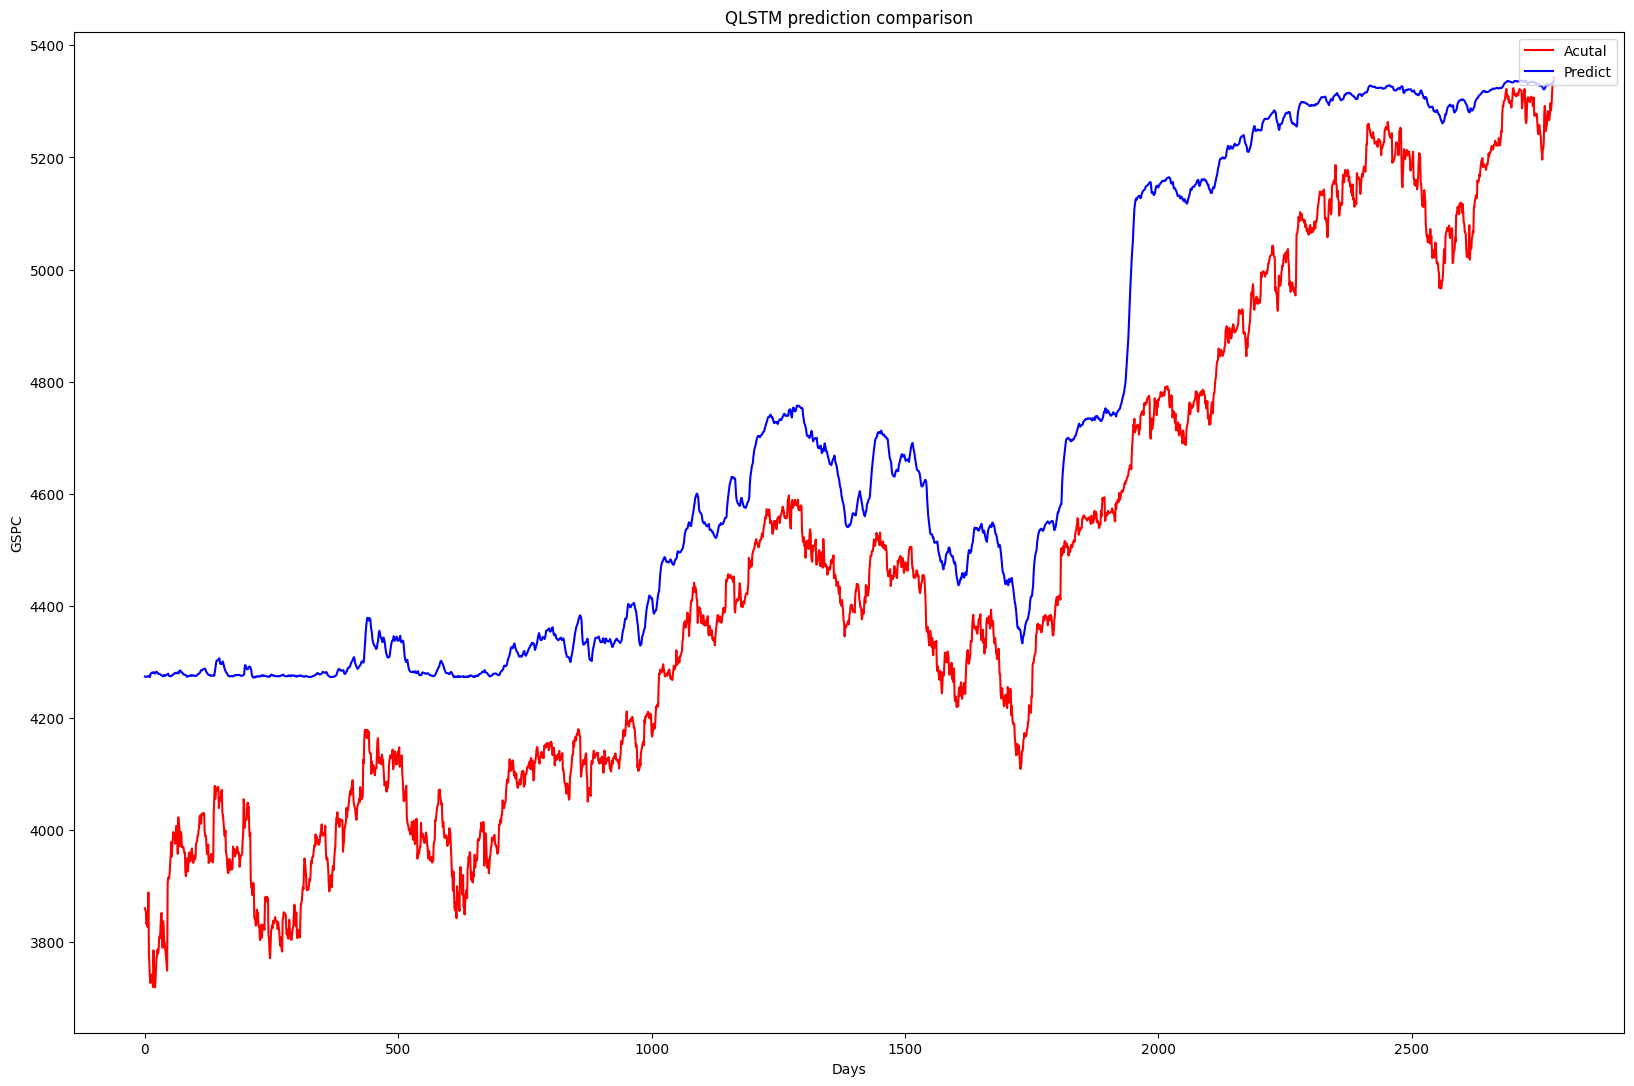

In [26]:
plt.figure(figsize=(20, 13))
plt.plot(y_train_true, color = 'red', label = 'Acutal')
plt.plot(y_train_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('GSPC')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:104.94789151549327


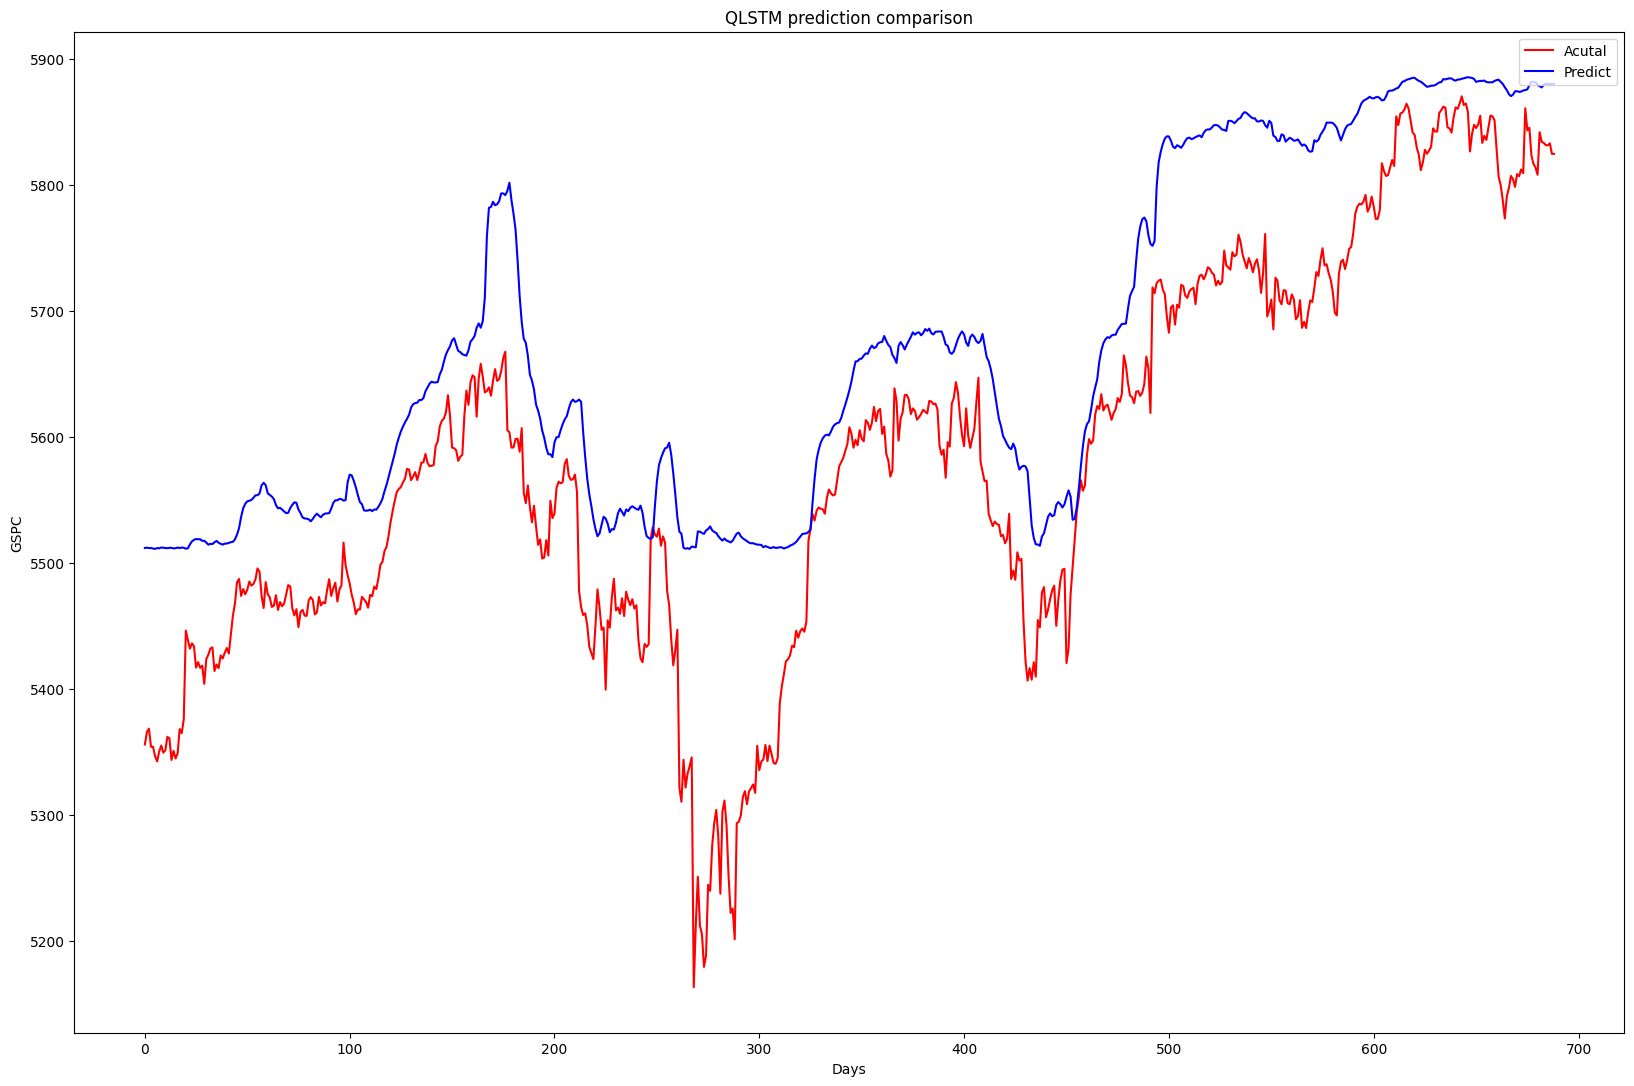

In [27]:
plt.figure(figsize=(20, 13))
plt.plot(y_test_true, color = 'red', label = 'Acutal')
plt.plot(y_test_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('GSPC')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

In [28]:
torch.save(modelQ,'./SavedModels/Stock/SNP500/model/CBLSTM_aqi')